# Scientific Computing:


Planetary motion and the precession of Mercury's orbit


### Introduction

Planet Earth orbits the Sun on an elliptical, closed orbit, as discovered by Kepler. This is described in Newtonian mechanics in terms of a gravitational force between Sun and Earth that falls with distance as $1/r^2$, where $r$ is the distance Earth-Sun. In the absence of perturbations from other planets, Newton's equations of motion then indeed results in elliptical closed orbits, as observed.

However, the orbit of planet Mercury - the planet closest to the Sun - is not well described by Newton's laws. Although the orbit is still approximately elliptical, it is not closed: the point of closest approach (called perihelion) precesses over succesive periods, as illustrated in the figure below (the precession is greatly exaggerated in the figure, to make it easier to see what is happening). Let's denote by $\theta$ the angle between the horizontal and the direction to the perihelion as seen from  Sun. For orbit 1 in the figure below, this angle is $\theta=\theta_1\approx \pi$. You can see from the figure that for orbit two, the perihelion no longer occurs
at $\theta=\theta_1$, but rather occurs at $\theta=\theta_2=\theta_1+\Delta\theta$: Mercury's orbit precesses (for a closed elliptical orbit, we would have $\theta_1=\theta_t$ so that $\Delta\theta=0$. The rate at which the angle evolves, is called the *precession rate*

**Precession rate = $\frac{\Delta\theta}{\Delta t}$**

where $\Delta t$ is the *period* of the orbit, *the time elapsed between two perihelion passages of the planet*.


The observed precession rate for Mercury = $\frac{\Delta\theta}{\Delta t}\approx 43$ arc seconds per century.
(Note: an arc second, denoted by arc sec, is 1 degree / 3600)

Several possible causes for the origin of this precession have been suggested in the past. Firstly, the presence of an (as of yet) undiscovered planet, called *Vulcan* - however, no such planet was ever found.

When Einstein published his theory of *General Relativity* (GR), he demonstrated that the small GR correction when applied to Mercury succesfully explained the precession of its orbit (the correction is larger for Mercury than for the Earth, because Mercury is so much closer to the Sun).

The GR correction can be simplified in case it is small, as is the case for Mercury. It results in a small correction term to Newton's law of gravity, which is called a *post-Newtonian correction*. The gravitational force is no longer $\propto 1/r^2$, but rather $\propto 1/r^2\left(1+\alpha/r^2\right)$. In this notebook we will try to determine the value of the physical constant $\alpha$, so that it reproduces the observed precession for Mercury. Notice that $\alpha$ has the dimension of a length times a length.

To do so, we need to write some code that integrates the orbit of a planet. We first do so in the Newtonian case, then we adapt it to include a post-Newtonian correction. We will use Euler's method as well as Euler-Cromer method.



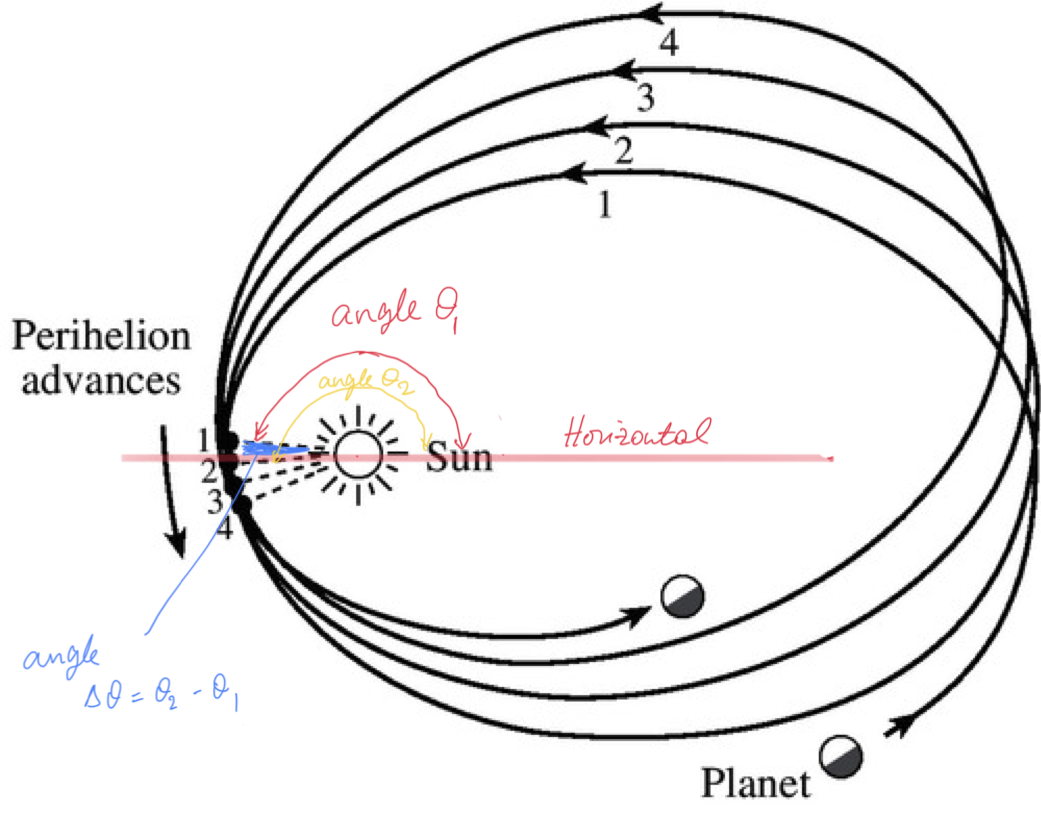

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import time


# Set-up
A planet of mass $m$ is on Keplerian orbit around a star of mass $M$, with $m\ll M$.
We will characterise the orbit by the three parameters, $(GM, r_a, \epsilon)$ where:

- $M$ is the mass of the star, and $G$ the value of Newton's constant. We will only ever use the product, $GM$
- $r_a$ is the aphelion distance (furthest distance from the star on the planet's orbit)
- $\epsilon$ is the eccentricity of the orbit (a measure of how elongated the ellipse is, $\epsilon=0$ for a circular orbit
    
From these, we can compute the energy per unit mass, $E/m$, and the angular momentum per unit mass, $L/m$.
We will simply refer to these as *energy* and *angular momentum*.


- $a = \frac{r_a}{1+\epsilon}$
- $\frac{E}{m}=-\frac{GM}{2a}=\frac{1}{2}v_a^2-\frac{GM}{r_a}$
- $\frac{L}{m}=r_a\,v_a=r_p\,v_p = |{\bf r}\times{\bf v}|$


Here, $a$ is the semi-major axis of the ellipse, $r_a$ is the distance planet-star at aphelion and $v_a$ is the speed at aphelion. Similarly, $r_p$ is the distance planet-star at perihelium, and $v_p$ is the speed at perihelium.

We choose the following set of units: express lengths in units of the astronomical unit, 1AU=149597870700 m (by definition), and GM in units of the value for the Sun, $(GM)_\odot=1.3272597\times 10^{20}~{\rm m}^3~{\rm s}^{-2}$.
The time unit will then be 1~year/$(2\pi)$.

Create a class Planet, which 
 - initializes the variable time, $t$, to $t=0$ (an arbitrary starting time of the integration)
 - initializes the value of GM, GM
 - initializes the value of x, a python array, containing $(x, v_x, y, v_y)$, where $(x,y)$ are the planet's Cartesian Coordinates, and $(v_x, v_y)=(\dot x, \dot y)$ are the planet's Cartesian velocities in the orbital plane.
 Initially, the values are then x = $(x(t=0)=r_a, y(t=0)=0, v_x(t=0)=0, v_y(t=0)=v_a)$
 - initializes the planet's period, period
 
The class should include three methods:
 - dx_dt: calculate the time derivative of the array x
 - energy: compute the energy, E/m, of the planet
 - angmom: compute the value of the angular momentum, L/m


In [3]:
class Planet:
    def __init__(self, GM, r_a, epsilon):
        """
        Initialize planetary parameters
        """
        # G*Mass of planet, GM
        self.GM = GM

        # Initialize time
        self.t      = 0.
    
        # set the array self.x, where the array x contains [x_0, vx_0, y_0, vy_0]
        # with (x_0,y_0)=(r_a,0), the position of the star at its aphelion
        # and  (vx_0, vy_0) the speed of the star there (those you need to compute)
        # inputs are:
        #   GM:      the mass of the planet times G, Newton's gravitational constant [units GMsun]
        #   r_a:     the aphelion distance planet-star [units AU]
        #   epsilon: the orbital eccentricity [dimensionless]
        
   
        x = np.zeros(4)

        # x_0=r_a
        # vx_0=0.0
        # y_0=0.0
        # vy_0=0.0
        # x=[x_0, vx_0,y_0,vy_0]

        x[0]=r_a #x_0
        x[1]=0.0 #vx_0
        x[2]=0.0 #y_0
        x[3]=0.0 #vy_0
        self.x = x
        #my code END
        
        
        # compute and set the period
        
        
        self.a= r_a/(1+epsilon)
        self.b=self.a*np.sqrt(1-(epsilon**2))
        self.r_0 = (1-(epsilon**2))*self.a
        self.r_p=self.a*(1-epsilon)
        #self.r_00= (1+epsilon)*r_a
        self.r_1= (1+epsilon)*self.a #maximum distance
        #print(self.r_0,self.r_1)
        period= np.sqrt((4*(np.pi**2)*(self.a**3))/self.GM)
        self.period = period
        self.x[3]= np.sqrt((self.GM/self.a) * ((1-epsilon)/(1+epsilon))) #calculating Vy
        self.v_y=self.x[3]
        self.v_x= (self.r_1*self.x[3]) / self.b #calcuating Vx
        
       



        
    def dx_dt(self):
        # The method returns dxdt, the time derivative of the vector self.x, where       
        #     self.x = [x(t), vx(t), y(t), vy(t)]
        #   and hence
        #   dxdt = [dx/dt, dvx/dt, dy/dt, dvy/dt]

        #  extract the current position and velocity of the planet
        x    = self.x[0]
        vx   = self.x[1]
        y    = self.x[2]
        vy   = self.x[3]
        dxdt = np.zeros(4) # initialize an array
        

        r=np.sqrt(self.x[0]**2 + self.x[2]**2)

        #Four first-order differential equations
        
        dx_dt = self.x[1]
        dvx_dt = -(self.GM/(r**3)) * self.x[0]
        dy_dt = self.x[3]
        dvy_dt = -(self.GM/(r**3)) * self.x[2]
        dxdt=[dx_dt,dvx_dt,dy_dt,dvy_dt]

        return dxdt


    
    def energy(self):
        # Compute and return the orbital energy per unit mass of the planet
        # Compute the 1/distance
        rinv = 1./np.sqrt(self.x[0]**2 + self.x[2]**2)
        # Gravitional energy, U
        U    = -self.GM * rinv
        # Kinetic energy, K
        K    = (1/2) * (self.x[1]**2 + self.x[3]**2)
        return U + K
    
    def angmom(self):
        # Compute and return the magnitude of the angular momentum per unit mass along the z-axis
        L = self.x[0] * self.x[3] - self.x[2] * self.x[1]
        return L
        

In [4]:

r_a     = 1.0
GM      = 1.0
epsilon = 0.5
planet = Planet(GM, r_a, epsilon)
position_test = planet.x
period_test   = planet.period
print(position_test, period_test)
print(planet.period)
print(planet.energy())
print(planet.angmom())
#print(planet.dx_dt())
print()
r_a     = 0.3
GM      = 3.0
epsilon = 0.1
planet = Planet(GM, r_a, epsilon)
position_test = planet.x
period_test   = planet.period
print(position_test, period_test)
print(planet.period)
print(planet.energy())
print(planet.angmom())


[1.         0.         0.         0.70710678] 3.420132880431637
3.420132880431637
-0.75
0.7071067811865476

[0.3 0.  0.  3. ] 0.5166686318724452
0.5166686318724452
-5.5
0.8999999999999999


In [5]:
# Use this cell to test your set-up of the planet
# If you get errors, then your set-up is likely incorrect.
# Otherwise your set-up might be correct


# Choose some planet properties
r_a     = 1.0   # perihelian distance [AU]
GM      = 1.0   # mass of star times G [GMsun]
epsilon = 0.5   # eccentricity [dimensionless]

planet = Planet(GM, r_a, epsilon)
assert np.all(np.isclose([1.0, 0.0, 0.0, 0.70710678], planet.x))   # check cartesian position and velocity
assert np.isclose(3.420132880431637, planet.period)                # check period [yr/2pi]
assert np.isclose(-0.75, planet.energy())                          # check energy per unit mass
assert np.isclose(0.7071067811865476, planet.angmom())             # check angular momentun per unit mass


# redo calculation for different properties
r_a     = 0.3
GM      = 3.0
epsilon = 0.1
planet = Planet(GM, r_a, epsilon)
assert np.all(np.isclose([0.3, 0., 0., 3.0], planet.x))
assert np.isclose(0.5166686318724452, planet.period)
assert np.isclose(-5.5, planet.energy())
assert np.isclose(0.9, planet.angmom())



# Implement the integrators

We will compute the planet's orbit numerically. To do so, we implement Euler's method and the Euler-Cromer method. 

In [6]:
class EulerCromerSolver():
    def __init__(self, system, dt):
        # Name is used to distinguish the two integrators
        self.name    = "EulerCromer"
        # System is the system to be integrated - planet
        self.system  = system
        # Constant time-step to be used in the integation
        self.delta_t = float(dt)
        
    def makeStep(self):
        # Implement one Euler-Cromer step. You have access to
        # system.x:      an array of the form (x, v_x, y, vy) (of position and velocity in Cartesian coordinates)
        # system.t:      current time
        # system.dx_dt:  the rate of change of system.x
        # self.dt:       the time step
        # returns: nothing
        # makeStep updates system.x  - new position and velocity after one step
        #                  system.t  - the current time after the time-step

        # rate of change of array x
        dx_dt = self.system.dx_dt()
        #self.x=dx_dt
        #print(dx_dt)

        # update x and t, given dx_dt and dt, using Euler-Cromer's method
        # YOUR CODE HERE
        self.system.x[1] = self.system.x[1] + dx_dt[1] * self.delta_t
        self.system.x[0] += self.system.x[1] * self.delta_t
        self.system.x[3] = self.system.x[3] + dx_dt[3] * self.delta_t
        self.system.x[2] += self.system.x[3] * self.delta_t
        self.system.t+=self.delta_t

In [7]:
class EulerSolver():
    def __init__(self, system, dt):
        # Name is used to distinguish the two integrators
        self.name    = "Euler"
        # System is the system to be integrated - planet
        self.system  = system
        # Constant time-step to be used in the integation
        self.delta_t = float(dt)
        
    def makeStep(self):
        # Implement one Euler step. You have access to
        # system.x:      an array of the form (x, v_x, y, vy) (of position and velocity in Cartesian coordinates)
        # system.t:      current time
        # system.dx_dt:  the rate of change of system.x
        # self.dt:       the time step
        # returns: nothing
        # makeStep updates system.x  - new position and velocity after one step
        #                  system.t  - the current time after the time-step
        #    
        
        # rate of change of array x
        dx_dt = self.system.dx_dt()

        # update x and t, given dx_dt and dt, using Euler's method
        
        self.system.x[0] += self.system.x[1] * self.delta_t
        self.system.x[1] = self.system.x[1] + dx_dt[1] * self.delta_t
        self.system.x[2] += self.system.x[3] * self.delta_t
        self.system.x[3] = self.system.x[3] + dx_dt[3] * self.delta_t
        
        self.system.t+=self.delta_t
        
        #-----another Euler approach-------
        
        # vx_old=self.system.x[1]
        # self.system.x[1] = self.system.x[1] + dx_dt[1] * self.delta_t
        # self.system.x[0] += vx_old * self.delta_t
        # vy_old=self.system.x[3]
        # self.system.x[3] = self.system.x[3] + dx_dt[3] * self.delta_t
        # self.system.x[2] += vy_old * self.delta_t


        
        
        

**Test Class**

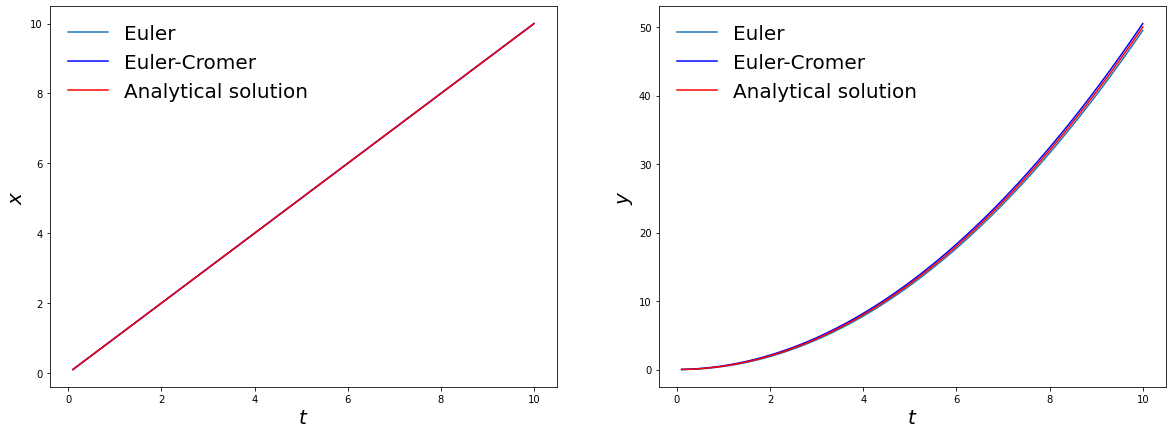

In [8]:
class TestClass:
    def __init__(self, x0, y0, vx0, vy0):
        """
        Initialize simple test case for integrators
        """
        # Initialize time
        self.t      = 0.
        # initialize x
        self.x      = [x0, vx0, y0, vy0]
    def dx_dt(self):
        # test simple case: constant speed in x, constant acceleration in y
        vx = self.x[1]
        vy = self.x[3]
        ax = 0.0  # no acceleration in x
        ay = 1.0  # constant acceleration in y
        return np.array([vx, ax, vy, ay])

# Compute the trajectory using both solvers and plot the result
test   = TestClass(0, 0, 1., 0.)
dt     = 0.1
nstep  = 100
x      = []
y      = []
t      = []
solver = EulerSolver(test, dt)
for i in range(nstep):
    step = solver.makeStep()
    x.append(test.x[0])
    y.append(test.x[2])
    t.append(test.t)

test   = TestClass(0, 0, 1., 0.)

xEC    = []
yEC    = []
tEC      = []
solver = EulerCromerSolver(test, dt)    
nstep  = 100
for i in range(nstep):
    step = solver.makeStep()
    xEC.append(test.x[0])
    yEC.append(test.x[2])
    tEC.append(test.t)
   
 # plot  path: vx(t) should be constant and hence x=vx * t
#             vy increases linearly in time, hence y=ay/2 t^2, with ay=1

fontsize=20
fig, ax = plt.subplots(1, 2, figsize = (20, 7))
# numerical solutions
ax[0].plot(t, x, label='Euler')
ax[0].plot(tEC, xEC, 'b', label='Euler-Cromer')
# analytical solution
ax[0].plot(t, t,'r', label='Analytical solution')
ax[0].set_xlabel(r'$t$', fontsize=fontsize)
ax[0].set_ylabel(r'$x$', fontsize=fontsize)
ax[0].legend(frameon=False, fontsize=fontsize)

# numerical solutions
ax[1].plot(t, y, label='Euler')
ax[1].plot(tEC, yEC, 'b',label='Euler-Cromer')
# analytical solution
ax[1].plot(t, 0.5*np.array(t)**2,'r',label='Analytical solution')
ax[1].set_xlabel(r'$t$', fontsize=fontsize)
ax[1].set_ylabel(r'$y$', fontsize=fontsize)
ax[1].legend(frameon=False, fontsize=fontsize)


The numerical results from the Euler integrator and the Euler-Cromer integrator (cyan and blue line, respectively)
should fall very close to or on top of the red line, which is the analytical solution.


In [9]:
# Now use both integration methods (Euler and EulerCromer) to evolve a planet with given orbital parameters

# Parameters of the planet
r_a     = 1.0     # aphelion distance [AU]
GM      = 1.0     # value of Newton's gravitational constant, G, times mass of the star [units of GM_sun]
epsilon = 0.1     # eccentricity of the orbit
planet = Planet(GM, r_a, epsilon)
print("Period = {}".format(planet.period))
planet1= Planet(GM, r_a, epsilon)

# choose the time-step to be a fraction of the period.
# To do so, we choose the number of steps per period, nsteps
nstep  = 2**8                         # number of integration steps per orbit
dt      = planet.period / float(nstep) # corresponding integration time step

# save initial position and initial time
x_0 = planet.x[0]
y_0 = planet.x[2]
four_end = planet.period*4
# print(dt,planet.period*4,(planet.period)/dt )
# print(x_0,y_0)
# print(planet.t)


Period = 5.4461655742666455


**plots to demonstrate the accuracy of the solvers**

1024

Relative Energy Error for Euler:[0.2121159729832271, 0.30733362841803036, 0.36282660522643523, 0.41642988036806206]
Relative Energy Error for EulerCromer:[1.7902945037562288e-06, 3.580629537919771e-06, 5.371004929093975e-06, 7.161420522453195e-06]

Relative Angular Momentum Error for Euler:[0.12152462442094898, 0.19511099901164444, 0.24668835505731432, 0.2983541797768742]
Relative Angular Momentum Error for EulerCromer:[5.851389114294502e-16, 1.5213611697165705e-15, 0.0, 1.6383889520024605e-15]

***** For Example- Relative energy Error with 2**8 steps on 4th period with Euler-Cromer is: 0.0007161420522453195 
***** which is consistent with the next-part calculations




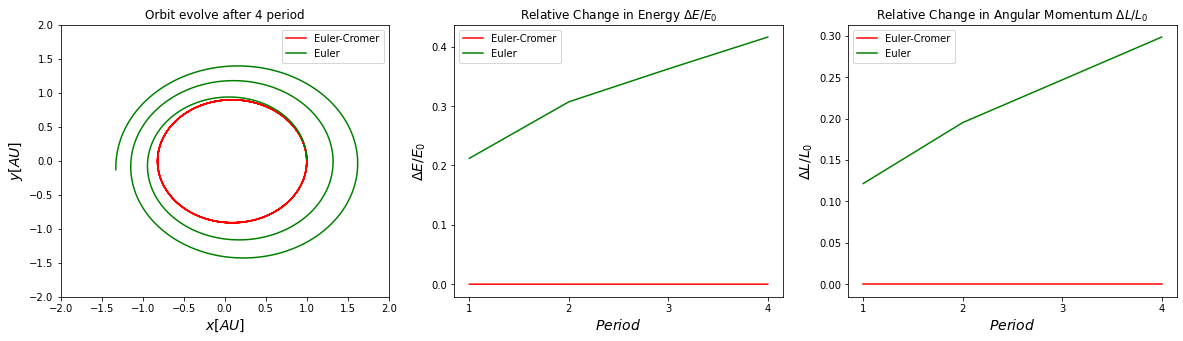

In [10]:
# Create three plots below:
# Plot 1: plot the orbit (x(t), y(t)), over 4 periods
# Plot 2: plot the relative change in energy, (E(t)-E(t=0))/E(t=0) as a function of time, t, in units of the period
# Plot 3: plot the relative change in angular momentum, (L(t)-L(t=0))/L(t=0) as a function of time, 
#     t, in units of the period
# Do so for both solvers (Euler and EulerCromer), plotting each method on each plot. Use
#   different colours to clarify which solver corresponds to which solution.
# Make sure you label the axes, and indicate which curve corresponds to which integration method





# #-----------------Euler-CROMER--------------------
four_end = planet.period*4
x1EC    = []
y1EC    = []
t1EC      = []
en1EC=[]
enAll1EC=[]
ang1EC=[]
g=0
solver = EulerCromerSolver(planet, dt)
en1EC.append(planet.energy())
ang1EC.append(planet.angmom())

while (float(planet.t)<float(four_end)):
    for j in range(nstep):
        if (planet.t>four_end):break
        step = solver.makeStep()
        x1EC.append(planet.x[0])
        y1EC.append(planet.x[2])
        t1EC.append(planet.t)
        enAll1EC.append(planet.energy())
        g+=1
    en1EC.append(planet.energy())
    ang1EC.append(planet.angmom())
print(g)
#planet.t+=dt  
#For Calculating energy and Angular Momentum on 4 periods, i create two loops, a while loop for each period and an inner 'for loop'
#for nsteps in each period, and after nsteps i save Energy and Angular Momentum into a list, now i have initial
#Energy and Angular momentum and the results in each period.
  

# #-----------------Euler--------------------
x1E    = []
y1E    = []
t1E      = []
en1E =[]
enAll1E=[]
ang1E=[]
solver1 = EulerSolver(planet1, dt)  
en1E.append(planet1.energy())
ang1E.append(planet.angmom())


while (float(planet1.t)<float(four_end)):
    for i in range(nstep):
        if (planet1.t>four_end):break
        step1 = solver1.makeStep()
        x1E.append(planet1.x[0])
        y1E.append(planet1.x[2])
        t1E.append(planet1.t)
        enAll1E.append(planet1.energy())
    en1E.append(planet1.energy())
    ang1E.append(planet1.angmom())

#planet1.t+=dt
#For Calculating energy and Angular Momentum on 4 periods, i create two loops, a while loop for each period and an inner 'for loop'
#for nsteps in each period, and after nsteps i save Energy and Angular Momentum into a list, now i have initial
#Energy and Angular momentum and the results in each period.



#----------------Results (just showing these results for better understanding)----------------

# print(f'Energy by Euler: {en1E}')
# print(f'Energy by EulerCromer: {en1EC}')
print()
relativeEC=[]
relativeE=[]
relativeEC1=[]
relativeE1=[]
for i in range(len(en1E)): relativeE.append(np.abs((en1E[i]-en1E[0])/en1E[0]))
relativeE1=relativeE[::-1]
print(f'Relative Energy Error for Euler:{relativeE[1:5]}')


for i in range(len(en1EC)): relativeEC.append(np.abs((en1EC[i]-en1EC[0])/en1EC[0]))
relativeEC1=relativeEC[::-1]
print(f'Relative Energy Error for EulerCromer:{relativeEC[1:5]}')

# print()
# print(f'Angular Momentum by Euler: {ang1E}')
# print(f'Angular Momentum by EulerCromer: {ang1EC}')
print()
relativeangEC=[]
relativeangE=[]
for i in range(len(ang1E)): relativeangE.append(np.abs((ang1E[i]-ang1E[0])/ang1E[0]))
print(f'Relative Angular Momentum Error for Euler:{relativeangE[1:5]}')
for i in range(len(ang1EC)): relativeangEC.append(np.abs((ang1EC[i]-ang1EC[0])/ang1EC[0]))
print(f'Relative Angular Momentum Error for EulerCromer:{relativeangEC[1:5]}')

print()
print(f'***** For Example- Relative energy Error with 2**8 steps on 4th period with Euler-Cromer is: {relativeEC[4]*100} \n***** which is consistent with the next-part calculations')

#--------------------Evolve FOUR Period----------------
fontsize=14
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
ax[0].set_xlim(-2,2)
ax[0].set_ylim(-2,2)
if epsilon==0: ax[0].set_aspect('equal', adjustable='box') #for better view on circle orbit
ax[0].plot(x1EC, y1EC, label='Euler-Cromer', color='red')
ax[0].plot(x1E, y1E, label='Euler' , color ='green')
ax[0].set_xlabel(r'$x[AU]$', fontsize=fontsize)
ax[0].set_ylabel(r'$y[AU]$', fontsize=fontsize)
ax[0].set_title("Orbit evolve after 4 period")
ax[0].legend() 

#-----------------------Energy--------------------------
ax[1].plot([1,2,3,4],[np.abs((en1EC[1]-en1EC[0])/en1EC[0]),np.abs((en1EC[2]-en1EC[0])/en1EC[0]),np.abs((en1EC[3]-en1EC[0])/en1EC[0]),np.abs((en1EC[4]-en1EC[0])/en1EC[0])],  label='Euler-Cromer', color='red')
ax[1].plot([1,2,3,4],[np.abs((en1E[1]-en1E[0])/en1E[0]),np.abs((en1E[2]-en1E[0])/en1E[0]),np.abs((en1E[3]-en1E[0])/en1E[0]),np.abs((en1E[4]-en1E[0])/en1E[0])],  label='Euler', color='green')
ax[1].set_ylabel(r'$\Delta E/E_{0}$', fontsize=fontsize)
ax[1].set_xlabel(r'$Period$', fontsize=fontsize)
ax[1].set_xticks([1,2,3,4])
#ax[1].set_yscale('log')
ax[1].set_title("Relative Change in Energy $\Delta E/E_{0}$")
ax[1].legend()
print()
#-----------------------Angular Momentum--------------------------
print()
ax[2].plot([1,2,3,4],[np.abs((ang1EC[1]-ang1EC[0])/en1EC[0]),np.abs((ang1EC[2]-ang1EC[0])/ang1EC[0]),np.abs((ang1EC[3]-ang1EC[0])/ang1EC[0]),np.abs((ang1EC[4]-ang1EC[0])/ang1EC[0])],  label='Euler-Cromer', color='red')
ax[2].plot([1,2,3,4],[np.abs((ang1E[1]-ang1E[0])/ang1E[0]),np.abs((ang1E[2]-ang1E[0])/ang1E[0]),np.abs((ang1E[3]-ang1E[0])/ang1E[0]),np.abs((ang1E[4]-ang1E[0])/ang1E[0])],  label='Euler', color='green')
ax[2].set_ylabel(r'$\Delta L/L_{0}$', fontsize=fontsize)
ax[2].set_xlabel(r'$Period$', fontsize=fontsize)
ax[2].set_xticks([1,2,3,4])
ax[2].set_title("Relative Change in Angular Momentum $\Delta L/L_{0}$")
ax[2].legend()


#***Euler-Cromer is more accurate, because the orbit is closed and it conserve energy sooner than Euler method, but with Euler method the orbit is not closed and energy is not conserved (on the given nstep=2^8).*** 


### Decreasing the time-step will improve energy conservation.
Plot the relative energy error in % after 4 orbits for both methods, as a function of nstep
(where the time step = period / 2^nstep).

Determine the minimum value of nstep, so that energy conservation is better than 1% for each method when integrating
the orbit for four periods.




nstep starts from 1

---------------------Results for EulerCromer-------------------
 E0=-0.55 and Energy-EulerCromer[nstep]=[3.9077282598934904, 0.23679703877001598, -0.3359991809275754, -0.5316235689884321, -0.547926268638627, -0.5497468614051328, -0.5499684713899906, -0.5499960612187127]
nstep=1 and relative energy error is %810.4960472533618
nstep=2 and relative energy error is %143.0540070490938
nstep=3 and relative energy error is %38.90923983134993
nstep=4 and relative energy error is %3.341169274830534
nstep=5 and relative energy error is %0.37704206570418364
nstep=6 and relative energy error is %0.04602519906676311
nstep=7 and relative energy error is %0.005732474547169953
nstep=8 and relative energy error is %0.0007161420522453195

---------------------Results for Euler-------------------
 E0=-0.55 and Energy-Euler[nstep]=[4.073238208896103, 1.1119134256874186, 0.26618929837765487, -0.03184559397973856, -0.17449210937760773, -0.19315011398193996, -0.2673516864668336, -0.32096

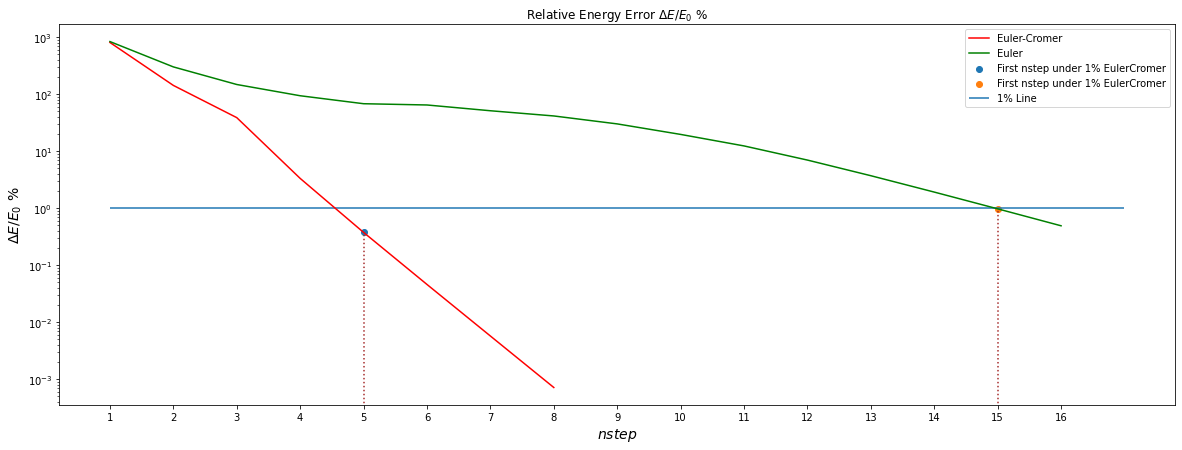

In [11]:

#########******* at this part I create two function for calculating Relative Energy Error % for both Euler and EulerCromer
# I send three variable (planet, dt, nstep) to the function and function will calculate the energy 
# and return the result after 4 period for each call, I save the results in a list and then  
# I set the Y-Axis in 'Log-Scale' for better View *********#########

# save initial position and initial time
x_0 = planet.x[0]
y_0 = planet.x[2]
e0=en1EC[0]
t_end = 4

#----------------------------Euler-CROMER-Function-------------------------------------------------------------------------
def calculateenergyEC(planetnewEC,dtneww,nstepnew):
    x2EC    = []
    y2EC    = []
    t2EC      = []
    en2EC=[]
    en2EC.clear()
    enAll2EC=[]
    ang2EC=[]
    angAll2EC=[]
 
    g=nstepnew
    l=dtneww
    solverEC = EulerCromerSolver(planetnewEC, dtneww)
    en2EC.append(planetnewEC.energy())
    ang2EC.append(planetnewEC.angmom())

    while (planetnewEC.t<=four_end):
        for j in range(2**g):
            stepEC = solverEC.makeStep()
            x1EC.append(planetnewEC.x[0])
            y1EC.append(planetnewEC.x[2])
            t1EC.append(planetnewEC.t)
            enAll1EC.append(planetnewEC.energy())
      
        planetnewEC.t+=dtneww
        en2EC.append(planetnewEC.energy())
        ang2EC.append(planetnewEC.angmom())
    return en2EC[-1]
    x2EC.clear(); y2EC.clear(); t2EC.clear(); en2EC.clear(); ang2EC.clear(); enAll2EC.clear(); angAll2EC.clear(); 


  
 #-------------------------------------Euler-CROMER-RESULTS--------------------

energyyEC=[]
print("nstep starts from 1")
print()
print("---------------------Results for EulerCromer-------------------")

for i in range(8):
    energyyEC.append(calculateenergyEC(Planet(GM, r_a, epsilon),planet.period / float(2**(i+1)),i+1))

print(f' E0={e0} and Energy-EulerCromer[nstep]={energyyEC}')
energyerrorEulerCromer=[]
for i in range(8):
    energyerrorEulerCromer.append(np.abs((energyyEC[i]-e0)/e0)*100)
    print(f'nstep={i+1} and relative energy error is %{np.abs((energyyEC[i]-e0)/e0)*100}')

#*******************************************************************************************************************#

#--------------------------------------------EULER-FUNCTION---------------------------------------------------------
def calculateenergyE(planetnewE,dtnewww,nstepnewww):
    x2E    = []
    y2E    = []
    t2E      = []
    en2E=[]
    en2E.clear()
    enAll2E=[]
    ang2E=[]
    angAll2E=[]
   
    g=0
    solverE = EulerSolver(planetnewE, dtnewww)
    en2E.append(planetnewE.energy())
    ang2E.append(planetnewE.angmom())
    while (planetnewE.t<=four_end):
        for j in range(2**nstepnewww):
            stepE = solverE.makeStep()
            x2E.append(planetnewE.x[0])
            y2E.append(planetnewE.x[2])
            t2E.append(planetnewE.t)
            enAll2E.append(planetnewE.energy())
         
        planetnewE.t+=dtnewww
        en2E.append(planetnewE.energy())
        ang2E.append(planetnewE.angmom())
    return en2E[-1]
    x2E.clear(); y2E.clear(); t2E.clear(); en2E.clear(); ang2E.clear(); enAll2E.clear(); angAll2E.clear(); 


# #------------------------------------Euler-RESULTS----------------------------------------------

energyyE=[]
print()
print("---------------------Results for Euler-------------------")

for i in range(16):
    energyyE.append(calculateenergyE(Planet(GM, r_a, epsilon),planet.period / float(2**(i+1)), i+1))

print(f' E0={e0} and Energy-Euler[nstep]={energyyE}')
energyerrorEuler=[]

for i in range(16): 
    energyerrorEuler.append(np.abs((energyyE[i]-e0)/e0)*100)
    print(f'nstep={i+1} and relative energy error is %{np.abs((energyyE[i]-e0)/e0)*100} ')

#*************************************************************************************************#
#-----------------------------------------PLOT----------------------------------------------------
from matplotlib.pyplot import figure
figure(figsize=(20, 7))
plt.plot(np.arange(1,9,1),energyerrorEulerCromer,  label='Euler-Cromer', color='red')
plt.plot(np.arange(1,17,1),energyerrorEuler,  label='Euler', color='green')
plt.ylabel(r'$\Delta E/E_{0} $ %', fontsize=fontsize)
plt.xlabel(r'$nstep$', fontsize=fontsize)
plt.xticks(np.arange(1,17,1))
plt.scatter(5,energyerrorEulerCromer[4],label='First nstep under 1% EulerCromer')
plt.scatter(15,energyerrorEuler[14],label='First nstep under 1% EulerCromer')
plt.yscale('log')
plt.vlines(5,0,energyerrorEulerCromer[4],linestyles='dotted', colors='brown')
plt.vlines(15,0,energyerrorEuler[14],linestyles='dotted', colors='brown')
plt.hlines(1,1,17,linestyles='solid', label='1% Line')
plt.title("Relative Energy Error $\Delta E/E_{0}$ %")
plt.legend()
plt.show()


# Post-Newtonian corrections

The orbit of a planet close to the Sun, such as Mercury, is affected by General Relativistic (GR) corrections
to the Newtonian description. Indeed, the perihelion of Mercury precesses as is predicted by GR, but not by Newtonian mechanics. The effect on Mercury's orbit is small but measurable. It can be described approximately by changing the form of the gravitational force from the Newtonian form, 
$${\bf F}=-\frac{GM}{r^3}{\bf r}$$
to 
$${\bf F}=-\frac{GM}{r^3}\left(1+\frac{\alpha}{r^2}\right){\bf r}$$
where $\alpha$ is a constant. Such a change to the force law is called a 'post-Newtonian' correction.

Adapt the planet class from above to include this new force law in the cell below, class Mercury. Set-up the class such that the value of $\alpha$ can be specified.


In [12]:
class Mercury:
    def __init__(self, GM, r_a, epsilon, alpha):
        """
        Initialize planetary parameters
        """
        # Mass of planet
        self.GM = GM

        # Initialize time
        self.t      = 0.
        
        # Initialize alpha
        self.alpha=alpha
    
        # set the array self.x, where the array x contains x[x_0, vx_0, y_0, vy_0]
        # with (x_0,y_0)=(r_a,0), the position of the star at its aphelion
        # and  (vx_0, vy_0) the speed of the star there.        
        # YOUR CODE HERE
         
        x = np.zeros(4)

        # x[0]=r_a #x_0
        # x[1]=0.0 #vx_0
        # x[2]=0.0 #y_0
        # x[3]=0.0 #vy_0
        self.x = x
        self.a= r_a/(1+epsilon)
        self.r_p=self.a*(1-epsilon)
        self.x[0] = (1+epsilon)*self.a
        self.x[1]=0.0
        self.x[2]=0.0
        self.b=self.a*np.sqrt(1-(epsilon**2))
        self.r_0 = (1-(epsilon**2))*self.a
        #self.r_00= (1+epsilon)*r_a
        self.r_1= (1+epsilon)*self.a #maximum distance
        #print(self.r_0,self.r_1)
        self.r=np.sqrt(self.x[0]**2 + self.x[2]**2)
        self.x[3]= np.sqrt((self.GM/self.a) * ((1-epsilon)/(1+epsilon))) #calculating Vy
        self.v_y=self.x[3]
        self.v_x= (self.r_1*self.x[3]) / self.b #calcuating Vx
        self.distance=epsilon*self.a
        # compute the period as if alpha=0
        # YOUR CODE HERE
        #period = np.sqrt(self.a**3) #Kepler's third law
        period= np.sqrt((4*(np.pi**2)*(self.a**3))/self.GM)
        self.period = period
         

        
    def dx_dt(self):
        # The method returns dxdt, the time derivative of the vector self.x, where       
        #     self.x = [x(t), vx(t), y(t), vy(t)]
        #   and hence
        #   dxdt = [dx/dt, dvx/dt, dy/dt, dvy/dt]
        # You may want to adapt the method implemented in the class Planet 
        #    to include the post-Newtonian correction due to non-zero alpha
        x   = self.x[0]
        vx  = self.x[1]
        y   = self.x[2]
        vy  = self.x[3]
         
        dxdt = np.zeros(4) # initialize an array
         
        # YOUR CODE HERE
        r=np.sqrt(self.x[0]**2 + self.x[2]**2)
        dx_dt = self.x[1]
        dvx_dt = -(self.GM/(r**3)) * (1+(self.alpha/r**2)) *  self.x[0]
        dy_dt = self.x[3]
        dvy_dt = -(self.GM/(r**3)) * (1+(self.alpha/r**2)) *  self.x[2]

        dxdt=[dx_dt,dvx_dt,dy_dt,dvy_dt]

        

        return dxdt
    
    def energy(self):
        # inverse distance
        rinv = 1./np.sqrt(self.x[0]*self.x[0] + self.x[2]*self.x[2])
        U    = -1 * rinv
        K    = (1/2) * (self.x[1]**2 + self.x[3]**2)
        return U + K
    
    def angmom(self):
        L = self.x[0] * self.x[3] - self.x[2] * self.x[1]
        return L

### Set-up an example of a planet like Mercury.

Integrate the orbit for 10.2 periods, $P$. Here the period $P$ is the value of the period in the case of $\alpha=0$.


**Do so for case $\alpha=0$ and $\alpha=0.01$.**

The value of the speed, $v=(v_x^2+v_y^2)^{1/2}$ is *heighest* when the planet is at its perihelion. So when recording
$(x(t),y(t),vx(t),vy(t))$ for each step of the orbit integration, you can easily identify the times $t_{p_i}$, $i=1\cdots n$ of successive perihelion passages. Given those times, you can calculate $\theta_{p_i}$, the angle of that perihelion passage, from $\tan(\theta_{p_i})=y(t_{p_i})/x(t_{p_i})$. 

Similarly, $v(t)$ is *smallest* when the planet is at its aphelion. Denote the corresponding time by $t_a$. Use this to compute the value of the angle $\theta$ at aphelion, $\theta(t_a)$.

From this, we can compute the precession rate rate, 

$$\dot\theta = \frac{\theta(t_{p_{i+1}})-\theta(t_{p_i})}{t_{p_{i+1}}-t_{p_i}}\,,$$

where $t_{p_i}$ is the time of the $i$-th perihelion passage, and $t_{p_{i+1}}$ the time that corresponds to the next perihelion passage. Be careful: make sure to restrict $\theta$ to the range $[-\pi,\pi]$ and ensure that
$\theta(t_{p_{i+1}})-\theta(t_{p_i})$ is always positive. You can similarly compute the rate using successive aphelion passages.

Make the plots as described in the cell below, and notice the precession of the orbit in the case $\alpha=0.01$.





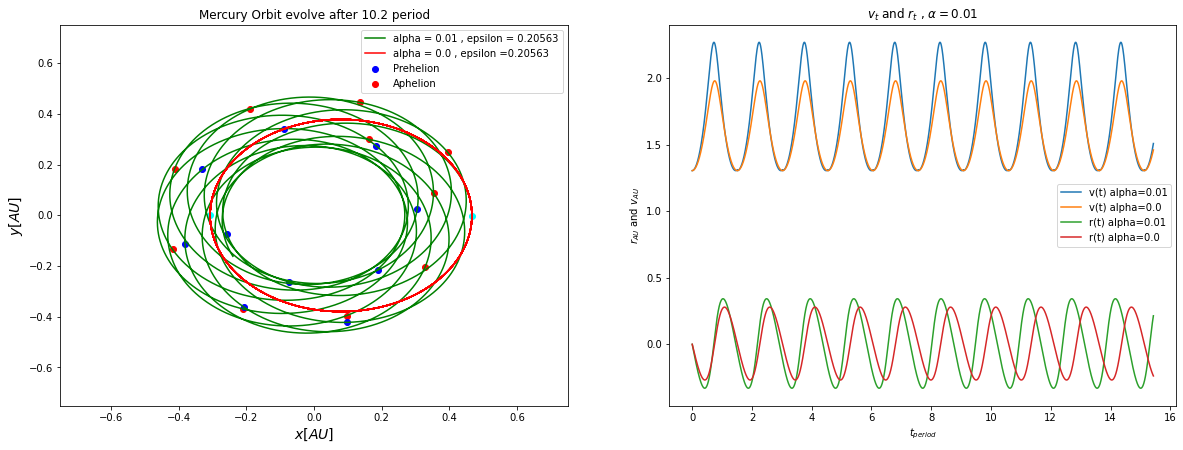

In [13]:
# set parameters for Mercury
r_a     = 0.466697    # AU
GM      = 1.0         # units GM_\odot
epsilon = 0.205630    # observed eccentrity of Merucy's orbit
#epsilon = 0.4
#epsilon = 0.8
#alpha = 0.0008
alpha   = 0.01        # assumes units of distance are in AU 
planet  = Mercury(GM, r_a, epsilon, alpha)

# save initial position and initial time
x_0 = planet.x[0]
y_0 = planet.x[2]

# choose time-step as a fraction of the period
nstep  = 2**10
dt     = planet.period / float(nstep)

# Calculate the resulting orbits here and save them. Then use the next cells to plot the orbits.
# You may want to save (x,vx,y,vy,t) as well as E/m and L/m, for every step along the orbit.
# Do so for both values of alpha.


from math import *
alpha0=0.0 #for alpha=0.0
planetm  = Mercury(GM, r_a, epsilon, alpha) #for alpha=0.1
planetm0  = Mercury(GM, r_a, epsilon, alpha0) #for alpha-0.0
planetperiod  = Mercury(GM, r_a, epsilon, 0.0) #for planet.period
theta_p=[]
theta_a=[]
theta_p0=[]
theta_a0=[]
#print(epsilon*planetm.a)
beta=10.2 #10.2 period
ten_end = planetperiod.period*beta
xmEC    = []
vxmEC    = []
ymEC    = []
vymEC    = []
emEC=[]
lmEC=[]
tmEC      = []
dr_dt=[]
speed_cal=[]
store_index=[]
d=[]
solver = EulerCromerSolver(planetm, dt)
ThetaPrecession=[]
TimePrecession=[]
while (float(planetm.t)<float(ten_end)):
    for i in range(nstep):
        if (planetm.t>ten_end):break
        step = solver.makeStep()
        xmEC.append(planetm.x[0])
        vxmEC.append(planetm.x[1])
        ymEC.append(planetm.x[2])
        vymEC.append(planetm.x[3])
        speed_cal.append(np.sqrt(vxmEC[i]**2 + vymEC[i]**2))
        emEC.append(planetm.energy())
        lmEC.append(planetm.angmom())
        tmEC.append(planetm.t)

k=0
if (beta==10.2):
    while (k<=nstep*beta):
        dr_dt.append((xmEC[k]*vxmEC[k]+ ymEC[k]*vymEC[k]) / planetm.r)
        k+=1
else:
    for i in range(nstep*beta):
        dr_dt.append((xmEC[i]*vxmEC[i]+ ymEC[i]*vymEC[i]) / planetm.r)
    

speed=[]
tempvx=[]
tempvy=[]
# z=1
# for z in range(beta):
#   for i in range(1024*(z-1),1024*z):
#     tempvx.append(vxmEC[i]**2)
#     tempvy.append(vymEC[i]**2)
#     speed.append(np.sqrt(vxmEC[i]**2 + vymEC[i]**2))
# print(speed)
# speed_temp=[]
# for u in range(len(vxmEC)):
#   speed_temp.append(np.sqrt(vxmEC[u]**2 + vymEC[u]**2))

# # print(speed_temp)
# max_xspeed_index=tempvx.index(max(tempvx))
# max_yspeed_index=tempvy.index(max(tempvy))
# print(np.sqrt(max(tempvx)**2 + max(tempvy)**2))
# print(tempvy.index(max(tempvy)))
# max_speed = max(speed)
# max_speed_index=speed.index(max_speed)
# min_speed = min(speed)
# min_speed_index=speed.index(min_speed)
# print(f'Max Speed is:{max_speed} and Min Speed is:{min_speed}')
# print(f'Max Speed Index is:{max_speed_index} and Min Speed Index is:{min_speed_index}')

# max_speed_temp = max(speed_temp)
# max_speed_temp_index=speed_temp.index(max_speed_temp)
# min_speed_temp = min(speed_temp)
# min_speed_temp_index=speed_temp.index(min_speed_temp)
# print(f'Max Speed is:{max_speed_temp} and Min Speed is:{min_speed_temp}')
# print(f'Max Speed Index is:{max_speed_temp_index} and Min Speed Index is:{min_speed_temp_index}')

#print(min(speed_cal), max(speed_cal))
v_min=[]
v_max=[]

speed_orbits = [speed_cal[x:x+1023] for x in range(0, len(speed_cal), 1023)] #Break the Speed values in 10 chunks, each chunks for one period

v_min=1.3046382810660786
v_max= 2.269989115971718
v_min_index=985
v_max_index=491


xm0EC    = []
vxm0EC    = []
ym0EC    = []
vym0EC    = []
em0EC=[]
lm0EC=[]
tm0EC      = []
speed_calm0=[]
solver0 = EulerCromerSolver(planetm0, dt)
while (float(planetm0.t)<float(ten_end)):
    for i in range(nstep):
        if (planetm0.t>ten_end):break
        step0 = solver0.makeStep()
        xm0EC.append(planetm0.x[0])
        vxm0EC.append(planetm0.x[1])
        ym0EC.append(planetm0.x[2])
        vym0EC.append(planetm0.x[3])
        speed_calm0.append(np.sqrt(vxm0EC[i]**2 + vym0EC[i]**2))
        em0EC.append(planetm0.energy())
        lm0EC.append(planetm0.angmom())
        tm0EC.append(planetm0.t)

dr_dtm0=[]

if (beta==10.2):
    k=0
    while (k<=nstep*beta):
        dr_dtm0.append((xm0EC[k]*vxm0EC[k]+ ym0EC[k]*vym0EC[k]) / planetm0.r)
        k+=1
else:
    for i in range(nstep*beta):
        dr_dtm0.append((xm0EC[i]*vxm0EC[i]+ ym0EC[i]*vym0EC[i]) / planetm0.r)

pre_alpha0=speed_calm0.index(max(speed_calm0))
aph_alpha0=speed_calm0.index(min(speed_calm0))


#------------------------------------------------------------------------------------
fontsize=14
fig, ax = plt.subplots(1, 2, figsize = (20, 7))
ax[0].set_xlim(-.75,.75)
ax[0].set_ylim(-.75,.75)
ax[0].plot(xmEC,ymEC, label=f'alpha = {alpha} , epsilon = {epsilon}' , color ='green')
ax[0].plot(xm0EC,ym0EC, label=f'alpha = {alpha0} , epsilon ={epsilon}' , color ='red')


ax[0].scatter(xm0EC[pre_alpha0],ym0EC[pre_alpha0], color='cyan')
ax[0].scatter(xm0EC[aph_alpha0],ym0EC[aph_alpha0], color='cyan')
ax[0].set_xlabel(r'$x[AU]$', fontsize=fontsize)
ax[0].set_ylabel(r'$y[AU]$', fontsize=fontsize)
ax[0].set_title("Mercury Orbit evolve after 10.2 period")





ax[0].scatter(xmEC[v_max_index],ymEC[v_max_index], color='blue',label='Prehelion')
ax[0].scatter(xmEC[v_min_index],ymEC[v_min_index], color='red',label='Aphelion')
for i in range(1,10):
    ax[0].scatter(xmEC[v_max_index+ (1024*i)],ymEC[v_max_index+ (1024*i)], color='blue')
    ax[0].scatter(xmEC[v_min_index+ (1024*i)],ymEC[v_min_index+ (1024*i)], color='red')

ax[0].legend()

ax[1].plot(tmEC,speed_cal, label=f'v(t) alpha={alpha}')
ax[1].plot(tm0EC,speed_calm0, label=f'v(t) alpha={alpha0}')
ax[1].plot(tmEC,dr_dt,label=f'r(t) alpha={alpha}') 
ax[1].plot(tm0EC,dr_dtm0,label=f'r(t) alpha={alpha0}') 
ax[1].set_xlabel(r'$t_{period}$')
ax[1].set_ylabel(r'$r_{AU}$ and $v_{AU}$')
ax[1].set_title(r'$v_{t}$ and $r_{t}$ , $\alpha=0.01$')
ax[1].legend()

#-----------------------------------------------------------------------------
theta_test=[]
theta_p.append(np.degrees(np.arctan(np.degrees(np.tan(np.radians(ymEC[204]/xmEC[204]))))))
theta_a.append(np.degrees(np.arctan(np.degrees(np.tan(np.radians(ymEC[0]/xmEC[0]))))))

for i in range(0,10):
      theta_p.append(np.degrees(np.arctan(np.degrees(np.tan(np.radians(ymEC[v_max_index+ (1024*i)]/xmEC[v_max_index+ (1024*i)]))))))


for i in range(0,10):
      theta_a.append(np.degrees(np.arctan(np.degrees(np.tan(np.radians(ymEC[v_min_index+ (1024*i)]/xmEC[v_min_index+ (1024*i)]))))))


theta_p0.append(np.degrees(np.arctan(np.degrees(np.tan(np.radians(ym0EC[204]/xm0EC[204]))))))
theta_a0.append(np.degrees(np.arctan(np.degrees(np.tan(np.radians(ym0EC[0]/xm0EC[0]))))))

for i in range(0,10):
      theta_p0.append(np.degrees(np.arctan(np.degrees(np.tan(np.radians(ym0EC[v_max_index+ (1024*i)]/xm0EC[v_max_index+ (1024*i)]))))))

# print(theta_p0)
for i in range(0,10):
      theta_a0.append(np.degrees(np.arctan(np.degrees(np.tan(np.radians(ym0EC[v_min_index+ (1024*i)]/xm0EC[v_min_index+ (1024*i)]))))))
t_p=[]
t_a=[]
t_p0=[]
t_a0=[]
t_p.append(tmEC[204])
t_a.append(tmEC[0])

t_p0.append(tm0EC[204])
t_a0.append(tm0EC[0])
for i in range(0,10):
      t_p.append(tmEC[v_max_index+ (1024*i)])

for i in range(0,10):
      t_a.append(tmEC[v_min_index+ (1024*i)])

for i in range(0,10):
      t_p0.append(tm0EC[v_max_index+ (1024*i)])

for i in range(0,10):
      t_a0.append(tm0EC[v_min_index+ (1024*i)])

### Plot the orbits as described in the cell below.

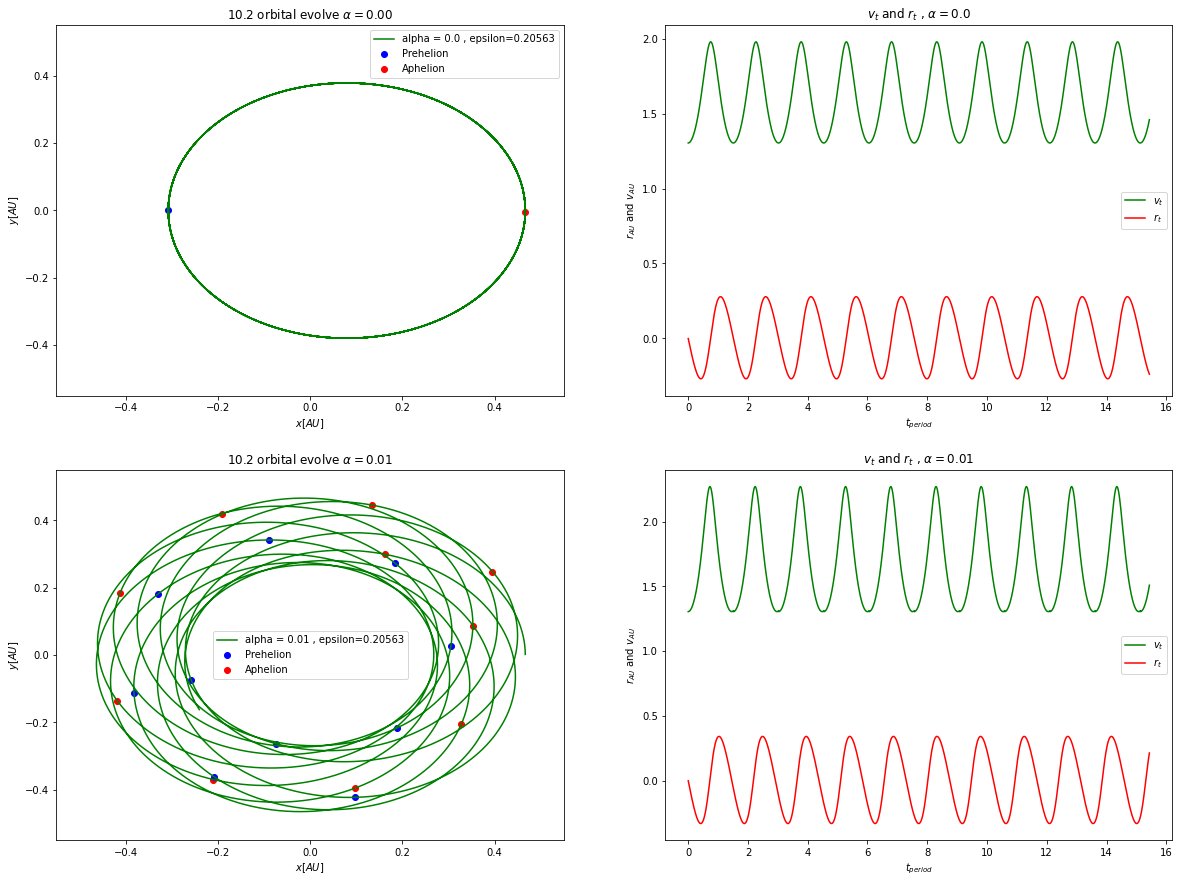

In [14]:
# Plot the orbits here. Make a 2 by 2 panel
# Upper two panels: plot the case of alpha=0
# Lower two panels: plot the case of alpha = 0.05
# Left panels:   plot the orbit of the planet, that is (x(t), y(t))
# Right panels:  plot the speed as a function of time, v(t), and the distance to the planet as a function of time, r(t)
# In all panels: indicate the location of the perihelion (location of closest approach) and aphelion
# (location of most distant point along the orbit).
# Identify these as: perihelion: v is a local maximum, aphelion: v is a local minimum
# Make sure you label all axes as well as the perihelion and aphelion.

# make sure figure is large enough
fig, ax  = plt.subplots(2, 2, figsize = (20, 15))
fontsize = 25


#print('****For better view you can set Epsilon=0.8 and Alpha=0.0008 from previous Cell****')
ax[0,0].set_xlim(-.55,.55);ax[0,0].set_ylim(-.55,.55);ax[1,0].set_xlim(-.55,.55);ax[1,0].set_ylim(-.55,.55)
ax[0,0].set_title(r'10.2 orbital evolve $\alpha =0.00$')
ax[0,0].set_xlabel(r'$x[AU]$')
ax[0,0].set_ylabel(r'$y[AU]$')
ax[0,0].plot(xm0EC,ym0EC, label=f'alpha = {alpha0} , epsilon={epsilon}' , color ='green')
ax[0,0].scatter(xm0EC[pre_alpha0],ym0EC[pre_alpha0], color='blue',label='Prehelion')
ax[0,0].scatter(xm0EC[aph_alpha0],ym0EC[aph_alpha0], color='red',label='Aphelion')

ax[1,0].set_xlabel(r'$x[AU]$')
ax[1,0].set_ylabel(r'$y[AU]$')
ax[1,0].set_title(r'10.2 orbital evolve $\alpha =0.01$')
ax[1,0].plot(xmEC,ymEC, label=f'alpha = {alpha} , epsilon={epsilon}' , color ='green')

ax[1,0].scatter(xmEC[v_max_index],ymEC[v_max_index], color='blue',label='Prehelion')
ax[1,0].scatter(xmEC[v_min_index],ymEC[v_min_index], color='red',label='Aphelion')
for i in range(1,10):
    ax[1,0].scatter(xmEC[v_max_index+ (1024*i)],ymEC[v_max_index+ (1024*i)], color='blue')
    ax[1,0].scatter(xmEC[v_min_index+ (1024*i)],ymEC[v_min_index+ (1024*i)], color='red')


ax[0,1].set_xlabel(r'$t_{period}$')
ax[0,1].set_ylabel(r'$r_{AU}$ and $v_{AU}$')
ax[0,1].set_title(r'$v_{t}$ and $r_{t}$ , $\alpha=0.0$')
ax[0,1].plot(tm0EC,speed_calm0, label='$v_{t}$', color ='green')
ax[0,1].plot(tm0EC,dr_dtm0,label='$r_{t}$', color ='red') 

ax[1,1].set_xlabel(r'$t_{period}$')
ax[1,1].set_ylabel(r'$r_{AU}$ and $v_{AU}$')
ax[1,1].set_title(r'$v_{t}$ and $r_{t}$ , $\alpha=0.01$')
ax[1,1].plot(tmEC,speed_cal, label='$v_{t}$', color ='green')
ax[1,1].plot(tmEC,dr_dt,label='$r_{t}$', color ='red')


ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
fig.show()

### Compute the precession rate of $\theta(t_p)$ and $\theta(t_a)$, for both values of $\alpha$.

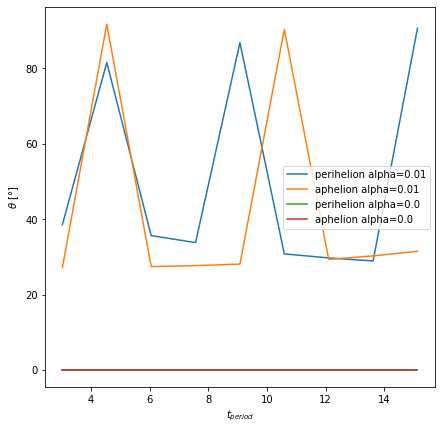

In [15]:
# Make a one panel plot of the rate $d\theta/t$ of the precession of the perihelion, and the aphelion angle. 
# Do so for both cases of alpha=0, and alpha=0.01.


# make sure figure is large enough
fig, ax  = plt.subplots(1, 1, figsize = (7, 7))
fontsize = 20
# YOUR CODE HERE
period=[]
for i in range(1,11):
    period.append(planetperiod.period*i)

theta_p_a=[]
theta_a_a=[]
theta_p_a0=[]
theta_a_a0=[]

for i in range(0,10):
    x=(np.abs(theta_p[i+1]-theta_p[i]))/(t_p[i+1]-t_p[i])
    if x>180:
        theta_p_a.append(360-x)
    elif x<-180:
        theta_p_a.append(x+360)
    else:theta_p_a.append(x)

for i in range(0,10):
    x=(np.abs(theta_a[i+1]-theta_a[i]))/(t_a[i+1]-t_a[i])
    if x>180:
        theta_a_a.append(360-x)
    elif x<-180:
        theta_a_a.append(x+360)
    else:theta_a_a.append(x)
        

for i in range(0,10):
    x=(np.abs(theta_p0[i+1]-theta_p0[i]))/(t_p0[i+1]-t_p0[i])
    if x>180:
        theta_p_a0.append(360-x)
    elif x<-180:
        theta_p_a0.append(x+360)
    else:theta_p_a0.append(x)



for i in range(0,10):
    x=(np.abs(theta_a0[i+1]-theta_a0[i]))/(t_a0[i+1]-t_a0[i])
    if x>180:
        theta_a_a0.append(360-x)
    elif x<-180:
        theta_a_a0.append(x+360)
        
    else:theta_a_a0.append(x)
  

    #plt.plot(tmEC,tcurve, label='prehelion alpha=0.01')
plt.plot(period[1:10],theta_p_a[1:10], label='perihelion alpha=0.01')
plt.plot(period[1:10],theta_a_a[1:10], label='aphelion alpha=0.01')
plt.plot(period[1:10],theta_p_a0[1:10], label='perihelion alpha=0.0')
plt.plot(period[1:10],theta_a_a0[1:10], label='aphelion alpha=0.0')

plt.ylabel(r"$\theta$ [$\degree$]")
plt.xlabel(r"$t_{period}$")
plt.legend()
fig.show()




### The value of $\alpha$ that gives the observed precession rate

For Mercury, the value observed for the perihelion precession rate is 0.43 arc seconds per century. We want to try to estimate which value of $\alpha$ gives the observed precession rate.

To do so, compute the precession rate, $\dot\theta$ for the case $\log_{10}\alpha=-9, -8, -7, -6$.
Convert this from the program units, to units of arc seconds per year.
Overplot the observed rate. Plot the logarithm base 10 of the precession rate, in arc sec per year.

Now vary the value of $\alpha$ to get the observed rate. Aim to get the estimate of $\alpha$ 
correct to 10\%.


calculation and plotting.

In [16]:
# Use this cell to do the calculations. No marks are assigned to this cell.

import math
import numpy as np
import matplotlib.pyplot as plt
r_a     = 0.466697    # AU
GM=4*(math.pi**2) # I use astronomical units

      
#epsilon = 0.205630    # observed eccentrity of Merucy's orbit
#epsilon = 0.4
#epsilon = 0.8
#alpha   = 0.01 
#alpha   = 0.0008        # assumes units of distance are in AU 

# physical constants

#alpha=0.0008
alpha_list=[0.000000001,0.00000001,0.0000001,0.000001]

evolve=0.72/3
#print(evolve)
r_a=0.466697

planet  = Mercury(GM, r_a, epsilon, alpha) 
color_list=['red','green','black','blue']
class precession:
    def __init__(self,epsilon,alpha,time,dt=0.0001):
        self.e=epsilon
        self.alpha=alpha
        self.a=r_a/(1+epsilon)
        self.x0=self.a*(1+epsilon)
        self.y0=0
        self.vx0=0
        self.vy0=np.sqrt((GM*(1-epsilon))/(self.a*(1+epsilon)))
        self.X=[self.x0]
        self.Y=[self.y0]
        self.Vx=[self.vx0]
        self.Vy=[self.vy0]
        self.T=[0]
        self.dt=dt
        self.time=time
        self.ThetaPrecession=[]
        self.TimePrecession=[]
        
        return None
    def calculate(self):
        while self.T[-1]<self.time:
            r=math.sqrt(self.X[-1]**2+self.Y[-1]**2)
            newVx=self.Vx[-1]-(GM*(1+self.alpha/r**2)*self.X[-1]/r**3)*self.dt
            newX=self.X[-1]+newVx*self.dt
            newVy=self.Vy[-1]-(GM*(1+self.alpha/r**2)*self.Y[-1]/r**3)*self.dt
            newY=self.Y[-1]+newVy*self.dt
            if abs(newX*newVx+newY*newVy)<0.0014 and r<self.a:
                theta=np.arccos(self.X[-1]/r)*180/math.pi
                if (self.Y[-1]/r)<0:
                    theta=360-theta
                theta=abs(theta-180)
                self.ThetaPrecession.append(theta*3600)
                self.TimePrecession.append(self.T[-1])
            self.Vx.append(newVx)
            self.Vy.append(newVy)
            self.X.append(newX)
            self.Y.append(newY)
            self.T.append(self.T[-1]+self.dt)
        return 0
    def plot(self,color='k',l=''):
        plt.plot(self.X,self.Y,color,label=l)
        return 0
    def orientation(self,color='k',l=''):
        plt.semilogy(self.TimePrecession,self.ThetaPrecession,c=color,label=l)
        #print (f'Tetha Precession alpha={self.alpha}: {self.ThetaPrecession}')
        #print(len(self.ThetaPrecession))
        #print (f'Time Precessionalpha={self.alpha}: {self.TimePrecession}')
        #print()
        return 0




*****PLEASE Be Patient, calculations are for 100 years!!******



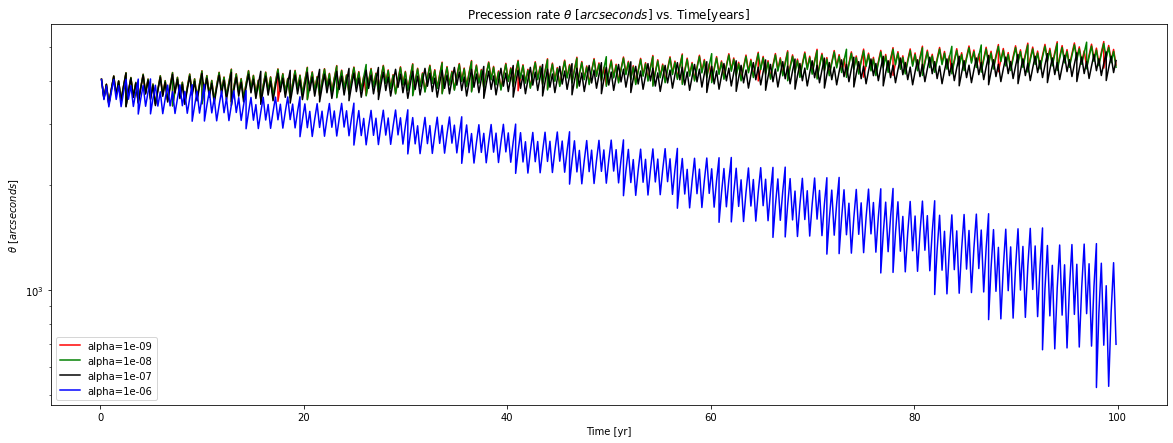

In [17]:
# Plot your results. Plot log of the precession rate (in arc sec per year) as a function of time over which you've simulate the orbit.
# Do so for all your computed values of alpha. Over plot the observed rate.



# make sure figure is large enough

fig, ax  = plt.subplots(1, 1, figsize = (20, 7))
fontsize = 20


print("*****PLEASE Be Patient, calculations are for 100 years!!******")
print()
year=100 # Change this for different years

Arc=[]
TIME=[]
for i in range(len(alpha_list)):
    A=precession(epsilon=0.205630,alpha=alpha_list[i],time=year)
    A.calculate()
    Arc.append(A.ThetaPrecession)
    TIME.append(A.TimePrecession)
    A.orientation(color=color_list[i],l=f'alpha={alpha_list[i]}')


# print(f'arcseconds for alpha = 1e-09: {Arc[0]}')
# print(f'arcseconds for alpha = 1e-08: {Arc[1]}')
# print(f'arcseconds for alpha = 1e-07: {Arc[2]}')
# print(f'arcseconds for alpha = 1e-06: {Arc[3]}')


plt.xlabel("Time [yr]")
plt.ylabel(r"$\theta$ [$arcseconds$]")
plt.title(r"Precession rate $\theta$ [$arcseconds$] vs. Time[years]")

plt.legend()
fig.show()


Report the value for $\alpha$ that you obtained in the cell below. Make sure to specify the physical units, and the uncertainty in your obtained result



In [18]:


print("*****PLEASE Be Patient, calculations are for 100 years for each alpha range!!******")
print()
print(f'for alpha=1e-06 AU\u00b2 the precession rate start to goes from tiny changes to more chaotic state')
print(f'for alpha=1e-07 AU\u00b2 the states are slightly better but not consistent as green and red graphs\n'
      f'but from alpha=1e-08 AU\u00b2 the rate is getting more stable for one century')
print(f'for the observed value and the plot from previous cell, we can confirm that the alpha value must be\n'
      f'between 1e-09 AU\u00b2 and 1e-08 AU\u00b2, so we can create a new alpha list between this range')
alpha_list09=np.arange(1.1*10**-9,1.5*10**-9,0.0000000001)
#print(alpha_list09)
alpha_list08=np.arange(1.1*10**-8,1.5*10**-8,0.000000001)
#print(alpha_list08)
color_list_new=['red','green','black','blue','teal']
ArcB=[]
TIMEB=[]
ArcC=[]
TIMEC=[]
for i in range(len(alpha_list09)):
    B=precession(epsilon=0.205630,alpha=alpha_list09[i],time=year)
    B.calculate()
    ArcB.append(B.ThetaPrecession)
    TIMEB.append(B.TimePrecession)


for i in range(len(alpha_list08)):
    C=precession(epsilon=0.205630,alpha=alpha_list08[i],time=year)
    C.calculate()
    ArcC.append(C.ThetaPrecession)
    TIMEC.append(C.TimePrecession)

pre_rateB=[]
pre_rateC=[]
for i in range(4):
    for j in range(len(ArcB[i])-1):
        pre_rateB.append((np.abs((ArcB[i][j+1]-ArcB[i][j]))/(TIMEB[i][j+1]-TIMEB[i][j]))/3600)

for i in range(4):
    for j in range(len(ArcC[i])-1):
        pre_rateC.append((np.abs((ArcC[i][j+1]-ArcC[i][j]))/(TIMEC[i][j+1]-TIMEC[i][j]))/3600)
        

print()

print("alpha in range 1e-09 AU\u00b2: ",min(pre_rateB[1320:1760]),min(pre_rateB[880:1320]),min(pre_rateB[440:880]),min(pre_rateB[0:440]))
print("alpha in range 1e-08 AU\u00b2: ",min(pre_rateC[1320:1760]),min(pre_rateC[880:1320]),min(pre_rateC[440:880]),min(pre_rateC[0:440]))
print()
print(f'As we can see the minimum precession is in range 1e-08 AU\u00b2 to 1.5e-08 AU\u00b2 \n'
      f'and to be more specific the minimum is at Alpha=1.1e-08 AU\u00b2')
print()
print(f'we can say that the observed precession is: 43\u00B10.4 arcseconds/century')





*****PLEASE Be Patient, calculations are for 100 years for each alpha range!!******

for alpha=1e-06 AU² the precession rate start to goes from tiny changes to more chaotic state
for alpha=1e-07 AU² the states are slightly better but not consistent as green and red graphs
but from alpha=1e-08 AU² the rate is getting more stable for one century
for the observed value and the plot from previous cell, we can confirm that the alpha value must be
between 1e-09 AU² and 1e-08 AU², so we can create a new alpha list between this range

alpha in range 1e-09 AU²:  0.40569558018177243 0.40569754972361466 0.4056995194447456 0.4057014888549835
alpha in range 1e-08 AU²:  0.40544741215413216 0.4054501989204024 0.4054698954666052 0.40550649997826044

As we can see the minimum precession is in range 1e-08 AU² to 1.5e-08 AU² 
and to be more specific the minimum is at Alpha=1.1e-08 AU²

we can say that the observed precession is: 43±0.4 arcseconds/century
